In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn as skl
import math as mt
import seaborn as sn
import matplotlib.pyplot as plt

from scipy import stats
from collections import Counter

In [2]:
currentFile = open("high_diamond_ranked_10min.csv")
dfInitial = pd.read_csv(currentFile)
#dfInitial
len(dfInitial.columns)

40

In [3]:
#Eliminer les outliers (peu/pas de monstres jungles tués, bcp de wards posées, peu de sbires tués)
#on s'en branle du gameID
#blueDeath et redDeath un peu useless, excepté pour quelques execute (on peut le vérifier)
#totalexp et avglevel c'est un peu la même
#se contenter de bluegoldiff et blueexpdiff
#totalminionkilled et minionperminutes
#same pour goldperminute et totalgold
#elitemonsters c'est juste la somme des drake et herald (osef)
#firstblood redondant (sauf dans les cas à 0 kills mais wsh c'est rare)
#TargetValue = blueWin

#To drop :
#gameId
#redAvgLevel, blueAvgLevel, redTotalExperience, blueTotalExperience,
#redTotalGold, blueTotalGold, redGoldPerMin, blueGoldPerMin,
#redCSPerMin, blueCSPerMin,
#redExperienceDiff, redGoldDiff, redFirstBlood

# Preprocessing

## Sélection de features

### Suppression des colonnes redondantes
De nombreuses features sont redondantes entre elles, on va donc les supprimer afin de simplifier notre dataset sans pour autant perdre de l'information.

**Les informations équivalentes sont les suivantes:**
* Le nombre total de sbires tués et le nombre moyen de sbires tués par chaque équipe.
* Le total d’or de chaque équipe, et la quantité d’or par minute (de même pour l'expérience).
* Le nombre total de monstres élite tués est en fait la somme des dragons et hérauts tués.
* Les différences d’or et d’expérience de l'équipe bleu, et celles de l'équipe rouges, peuvent être obtenues grâce au total d'or et d'expérience des 2 équipes
* Le nombre total de sbires tués et le nombre de sbires tués par minutes par chaque équipe.
* Les morts de chaque équipe sont intimement liés aux kills de l’équipe adverse, bien que la correspondance ne soit pas parfaite dans certaines parties.
* Le booléen “first-blood”, indiquant si l'équipe est la première a avoir fait un kill, est présent pour les 2 équipes.

**Autre:**
* Le gameID permet d'identifier la partie, ce qui n’est pas utile à notre analyse

Lorsque chaque équipe possède une feature réprésentant la même information, on privilégiera celle de l'équipe bleue (ex. pour la différence d'or on supprimera redGoldDiff)

In [4]:
toDrop = ["gameId", "redAvgLevel", "blueAvgLevel", "redTotalExperience", "blueTotalExperience",
          "redTotalGold", "blueTotalGold", "redGoldPerMin", "blueGoldPerMin", "redCSPerMin","blueCSPerMin",
          "redExperienceDiff", "redGoldDiff", "redFirstBlood", "redEliteMonsters", "blueEliteMonsters"]
dfSimplified = dfInitial.drop(toDrop, axis = 1)
#dfSimplified
len(dfSimplified.columns)

24

### Colonnes redDeaths et redKills
Les morts et les éliminiations d'une équipe sont fortement liées aux éliminations et aux morts de l'autre équipe, mais il est possible que la mort d'un joueur ne compte pas comme une élimination pour l'équipe adverse, on parle alors d'exécution. Nous allons nous intéresser au nombre de parties où ces données diffèrent afin de déterminer s'il est pertinent de supprimer ces features, ou si cela nous ferait perdre trop d'information

In [5]:
dfExecute = dfSimplified[(dfSimplified["redDeaths"] != dfSimplified["blueKills"]) | (dfSimplified["redKills"] != dfSimplified["blueDeaths"])]
len(dfExecute)

0

On remarque que notre dataset ne contient pas de parties dans laquelle un joueur a été exécuté, nous pouvons donc supprimer ces features sans perdre de l'information

In [6]:
dfSimplified = dfSimplified.drop(["redDeaths", "redKills"], axis = 1)
#dfSimplified
len(dfSimplified.columns)

22

### Monstres élites
On sait qu'il ne peut y avoir qu'un seul héraut de la faille, et un seul dragon dans les 10 premières minutes, on peut donc fusionner les 2 colonnes blueHeralds et redHeralds (resp. blueDragons et redDragons) on aurait alors 3 valeurs possible : 1, 0 et -1 correspondant respectivement à blue, red et none

In [7]:
colEliteMonsters = dfSimplified[["blueHeralds", "redHeralds", "redDragons", "blueDragons"]]
colEliteMonsters.loc[:, ['herald', 'dragon']] = -1
def convertEliteStats(dataframe):
    for index, current in dataframe.iterrows():
        if current['blueHeralds'] == 1:
            current['herald'] = 1
        elif current['redHeralds'] == 1:
            current['herald'] = 0
        if current['blueDragons'] == 1:
            current['dragon'] = 1
        elif current['redDragons'] == 1:
            current['dragon'] = 0
    return dataframe[["herald", "dragon"]]

dfSimplified = dfSimplified.drop(["redHeralds", "blueHeralds", "redDragons", "blueDragons"], axis = 1);
dfSimplified[["herald", "dragon"]] = convertEliteStats(colEliteMonsters)
#dfSimplified
len(dfSimplified.columns)

<ipython-input-7-cd6581752390>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  colEliteMonsters.loc[:, ['herald', 'dragon']] = -1


20

# Dédoubler les données

## Objectif
Doubler nos données permettrait d'augmenter virtuellement la taille de notre dataset, et donc d'avoir un modèle mieux entraîné et globalement plus fiable.
## Problème
Le jeu est fait de sorte que chaque équipe ai les même chances de gagner, cependant un aspect important du jeu n'est pas symétrique : les monstres élites.
Les monstres élites (dragons et hérauts de la faille) offrent de nombreux avantages aux joueurs (or, expérience, statistiques, prise de tour), mais dû à la forme de la carte, chaque équipe est théoriquement avantagée sur la prise d'un type de monstre élites.

![L'image Lol_Map.png n'a pas pu être chargé](images/LoL_Map.png) 
## Principe
Nous allons donc comparer la prévalence des différents monstres élites dans les parties gagnées, ainsi que la proportion de parties où les différents objectifs ont été pris par chaque équipe. Si les monstres élites influent peu sur le taux de victoire, ou si chaque équipe a en réalité le même nombre de monstre élite en moyenne, alors nous pourrons considérer doubler les données.

In [8]:
def EliteMonsterRepartition(dataframe, in_col):
    cols = dataframe[dataframe[in_col] > -1]
    blue = 0
    red = 0
    amount = []

    for index, current in cols.iterrows():
        if current[in_col] == 1:
            blue += 1
        elif current[in_col] == 0:
            red += 1
        amount.append(1)

    #g = sn.barplot(x=in_col,y=amount,data=cols)
    #g.set(xticklabels=["Red team", "Blue team"])
    plt.figure(figsize=(6,5), dpi=80)
    plt.xlabel("Équipes", size=14)
    plt.xticks(size=11)
    plt.ylabel("Nombre de parties", size=14)
    plt.bar(['Red team', 'Blue team'], height = [red, blue], color = ['red', 'blue'])
    plt.title("Répartition du " + in_col + " par équipe")
    plt.savefig("images/" + in_col + '.png', bbox_inches='tight')

    plt.show()
    print(in_col, 'bleus :', blue)
    print(in_col, 'rouges :', red)
    print('Un ' + in_col + ' est fait par l\'équipe bleue dans ' + str(round(100*blue/len(dataframe), 1)) + '% des parties')
    print('Un '+ in_col + ' est fait par l\'équipe rouge dans ' + str(round(100*red/len(dataframe), 1)) + '% des parties')

### Hérauts de la faille

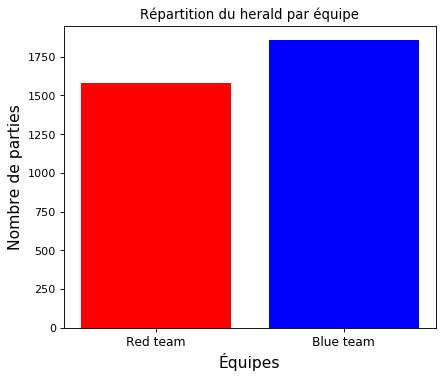

herald bleus : 1857
herald rouges : 1581
Un herald est fait par l'équipe bleue dans 18.8% des parties
Un herald est fait par l'équipe rouge dans 16.0% des parties


In [9]:
EliteMonsterRepartition(dfSimplified, 'herald')

On voit effectivement que l'équipe bleu est avantagée sur la prise des hérauts, la probabilité que l'équipe bleue fasse le héraut est plus élevée de presque 3%. 

### Dragons

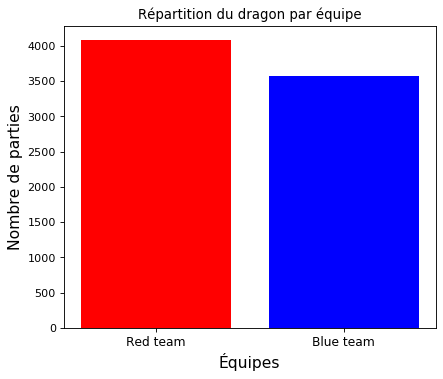

dragon bleus : 3576
dragon rouges : 4081
Un dragon est fait par l'équipe bleue dans 36.2% des parties
Un dragon est fait par l'équipe rouge dans 41.3% des parties


In [10]:
EliteMonsterRepartition(dfSimplified, 'dragon')

On voit effectivement que l'équipe rouge est avantagée sur la prise des dragons, la probabilité que l'équipe rouge fasse le dragon est plus élevée de 5%. 

## Analyse

On a vérifié que les équipes avaient bien un avantage sur l'accès à un type d'objectif, on s'intéresse maintenant à l'impact que chaque objectif a sur la victoire

In [11]:
def WinRepartition(df):
    cols = df[["blueWins", "herald", "dragon"]]
    dragon = 0
    herald = 0
    dragonG = 0
    heraldG = 0
    amountDragon = 0
    amountHerald = 0
    #amount = []
    
    for index, current in cols.iterrows():
        if current["blueWins"] == current["dragon"]:
            dragonG += 1
        if current["blueWins"] == current["herald"]:
            heraldG += 1
        if current["dragon"] > -1:
            dragon += 1
        if current["herald"] > -1:
            herald += 1
        #amount.append(1)
    
    plt.figure(figsize=(6,5),dpi=80)
    plt.xlabel("Monstres élites", size=14)
    plt.xticks(size=11)
    plt.ylabel("Nombre de parties", size=14)
    plt.yticks(np.arange(0, len(df), 500))
    plt.bar(['Dragon', 'Héraut'], height = [dragonG, heraldG], color = ['orange', 'purple'])
    plt.title("Nombre de monstres élites pris par l'équipe gagnante")
    plt.savefig('images/Elite_Monsters_Repartition.png', bbox_inches='tight')

    plt.show()
    print(dragonG, "(" + str(round(100*dragonG/dragon, 1)) + "%)" + ' des dragons ont été pris par l\'équipe gagnante')
    print(heraldG, "(" + str(round(100*heraldG/herald, 1)) + "%)" + ' des hérauts ont été pris par l\'équipe gagnante')
    print('Sur un total de ' + str(len(df)) + ' parties')

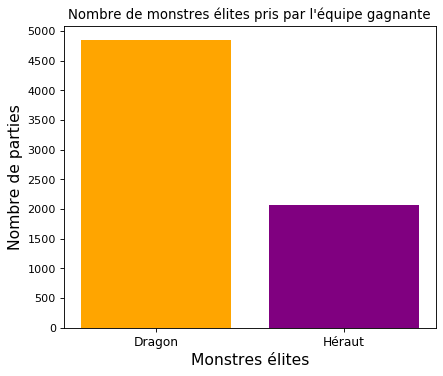

4846 (63.3%) des dragons ont été pris par l'équipe gagnante
2073 (60.3%) des hérauts ont été pris par l'équipe gagnante
Sur un total de 9879 parties


In [12]:
WinRepartition(dfSimplified)

## Bilan
Les dragons sont plus faciles à prendre pour l'équipe rouge et ont une meilleure corrélation avec la victoire que les hérauts.  
Bien que l'avantage ne soit que de quelques pourcents, il est trop important pour qu'on puisse doubler de manière fiable les données.

# Chances de victoires
Nous venons de nous intéresser aux chances de victoires de l'équipe obtenant un monstre élite dans les 10 premières minutes, et déterminer que celles-ci sont sensiblement plus élevées.  
Nous allons maintenant visualiser comment d'autres statistiques du début de partie sont liées à l'issue de celle-ci.

### Double objectif
On s'intéresse dans cette section aux parties dans lesquelles les 2 monstres élites ont été pris par la même équipe.

In [13]:
dfDouble = dfSimplified[["blueWins", "herald", "dragon"]]
dfDouble = dfDouble[(dfDouble["herald"] > -1) & (dfDouble["dragon"] > -1)]
dfDouble = dfDouble[dfDouble["herald"] == dfDouble["dragon"]]

In [14]:
#taux de victoire de l'équipe ayant les 2 objectifs dans la même partie
def DoubleWinRepartition(df):
    blueDoubleWin = 0
    redDoubleWin = 0
    win = 0
    blueTotal = 0
    redTotal = 0
    
    for index, current in df.iterrows(): #len(df) iterations
        if current["blueWins"] == current["herald"]: #si le gagnant == double
            win += 1
            if current["blueWins"] == 1: #si c'est les bleus qui ont gagné
                blueDoubleWin += 1
                blueTotal += 1
            else: #si c'est les rouges
                redDoubleWin += 1
                redTotal += 1
        else: #si le perdant == double
            if current["blueWins"] == 1: #le perdant est rouge 
                redTotal += 1
            else: #le perdant est bleu
                blueTotal += 1
    
    plt.figure(figsize=(6,5), dpi=80)
    plt.xlabel("Équipes", size = 14)
    plt.xticks(size=11)
    plt.ylabel("Nombre de parties", size = 14)
    plt.bar(["Blue team", "Red team", "Total de parties"], height = [blueTotal, redTotal, len(df)], color=["blue", "red", "green"])
    plt.title("Nombre de parties lors de laquelle une équipe a obtenu 2 monstres élites")
    plt.savefig('images/Double_Elite_Amount.png', bbox_inches='tight')
    
    plt.show()
    
    print("Les 2 monstres élites ont été fait par la même équipe dans", len(df), "parties", "(" + str(round(100*len(df)/len(dfSimplified), 1)) + "%)")
    print("Parmi ces parties,", blueTotal, "(" + str(round(100*blueTotal/len(df), 1)) +"%)", "ont été fait par l'équipe bleue", "et", redTotal, "(" + str(round(100*redTotal/len(df), 1)) +"%)", "ont été fait par l'équipe rouge")
    
    plt.figure(figsize=(6,5), dpi=80)
    plt.xticks(size=11)
    plt.xlabel("Équipes", size=14)
    plt.ylabel("Nombre de parties", size=14)
    plt.yticks(np.arange(0, len(df), 100))
    plt.bar(['Blue team', 'Red team', 'Total de victoire'], height = [blueDoubleWin, redDoubleWin, win], color = ['blue', 'red', 'green'])
    plt.title("Nombre de victoires par une équipe ayant obtenu les 2 monstres élites")
    plt.savefig('images/Double_Elite_Winrate.png', bbox_inches='tight')

    plt.show()
    print("Parmi les parties où les 2 monstres élites ont été fait par la même équipe,", win, "("+ str(round(100*win/len(df))) +"%)" , "ont mené à une victoire")
    print("Parmi ces parties, l'équipe bleue a gagné", blueDoubleWin, "(" +str(round(100*blueDoubleWin/blueTotal, 1))+"%)", "fois,", "et l'équipe rouge", redDoubleWin, "("+ str(round(100*redDoubleWin/redTotal, 1)) +"%)", "fois")
    

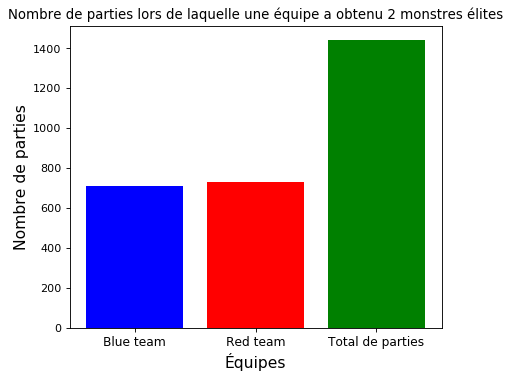

Les 2 monstres élites ont été fait par la même équipe dans 1440 parties (14.6%)
Parmi ces parties, 710 (49.3%) ont été fait par l'équipe bleue et 730 (50.7%) ont été fait par l'équipe rouge


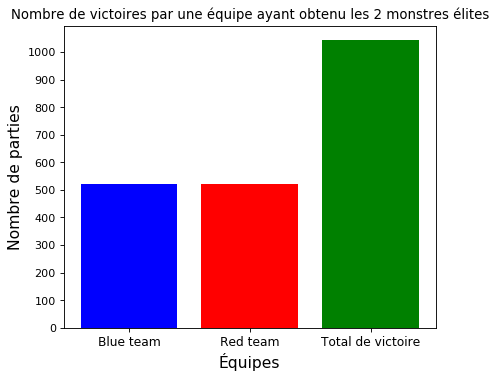

Parmi les parties où les 2 monstres élites ont été fait par la même équipe, 1043 (72%) ont mené à une victoire
Parmi ces parties, l'équipe bleue a gagné 522 (73.5%) fois, et l'équipe rouge 521 (71.4%) fois


In [15]:
DoubleWinRepartition(dfDouble)

On voit que les 2 équipes obtiennent un double-objectif en proportion égale, avec un léger avantage pour l'équipe rouge. Cela peut s'expliquer par le fait que cette équipe possède un avantage sur la prise du dragon, qui est un objectif bien plus disputer que le héraut de la faille.  
Une équipe qui parvient à sécuriser ces 2 objectifs dès le début de la partie a 7 chances sur 10 d'être la future équipe gagnante. Cel fait sens, puisque réussir à obtenir les deux monstres élites en 10 minutes donne un net avantage pour la suite de la partie, mais témoigne aussi d'une avance par rapport à l'équipe adverse, que ce soit en terme de statistiques pures, en terme de coordination d'équipe, ou même de contrôle de la carte. C'est donc un excellent indicateur des chances de victoire d'une équipe.

### Tourelles
Les tourelles empêchent l'équipe adverse d'avancer librement sur la carte, les détruire permet donc de prendre le contrôle et rapporte une quantité conséquente d'or à toute l'équipe.  
On s'intéresse dans cette section au nombre de tours prises, ainsi qu'au nombre de tour prise par l'équipe gagnante.

In [16]:
#taux de victoire en fonction du nombre de tourelles prises
def WinrateByTowers(df):
    towersDestroyed = []
    win = []
    
    for index, current in df.iterrows():
        towersDestroyed.append(current["blueTowersDestroyed"])
        towersDestroyed.append(current["redTowersDestroyed"])
        if current["blueWins"] == 1:
            win.append(current["blueTowersDestroyed"])
        else:
            win.append(current["redTowersDestroyed"])
        
    plt.figure(figsize=(8,6), dpi=80)
    plt.hist(towersDestroyed,bins = 4)
    plt.hist(win, bins = 4)
    plt.title("Nombre de tours détruites pas parties, et nombre de tours détruites par l'équipe gagnante", fontsize=13)
    plt.xlabel("Nombre de tours détuites", fontsize=16)
    plt.xticks(np.arange(0.5, 4.5, 1), [1, 2, 3, 4], fontsize=12)
    plt.yticks(np.arange(0, 20000, 1000), fontsize=12)
    plt.ylabel("Nombre de parties", fontsize=16)
    #plt.yscale("log")
    plt.legend(["Nombre de tours détruites par partie", "Nombre de tours détruites par une équipe victorieuse"])
    plt.savefig('images/Towers_Destroyed.png', bbox_inches='tight')
    
    plt.show()

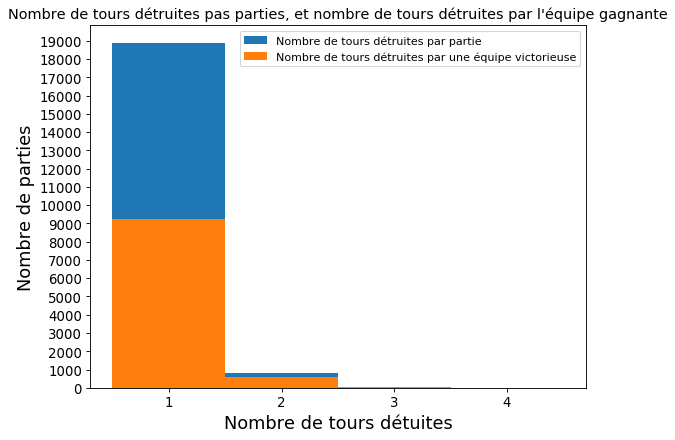

In [17]:
WinrateByTowers(dfSimplified)

On remarque qu'il est fréquent qu'une des 2 équipes détruise une tour dans les 10 premières minutes, mais ceci n'est en aucun révélateur de l'équipe qui gagnera la partie. En revanche, si une équipe parvient à détruire plus de tour dans ce laps de temps, il est très probable que cette équipe gagne. Cela est d'autant plus valide, que pour qu'une équipe détruise 3 tours ou plus dans les 10 premières minutes, il faut que l'équipe adverse abandonne ou se laisse faire.

### Premier-sang
Le "premier-sang" est la première élimination de la partie, elle donne un léger bonus d'or et permet à un joueur de prendre l'avantage dès le début de la partie. On s'attend naturellement à ce que l'équipe obtenant le premier-sang ai plus de chance de victoires, ce que l'on va vérifier.

In [18]:
#taux de victoire de l'équipe ayant le premier sang
def firstBloodRepartition(df):
    bluefb = 0
    redfb = 0
    win = 0
    
    for index, current in df.iterrows():
        
        if current["blueWins"] == current["blueFirstBlood"]:
            win += 1
        if current["blueFirstBlood"] == 1:
            bluefb += 1
        else:
            redfb += 1
    
    plt.figure(figsize=(6,5), dpi=80)
    plt.xlabel("Équipes", size=14)
    plt.xticks(size=11)
    plt.ylabel("Nombre de parties", size=14)
    plt.yticks(np.arange(0, len(df), 500))
    plt.bar(['Blue team', 'Red team', 'Total de victoire'], height = [bluefb, redfb, win], color = ['blue', 'red', 'green'])
    plt.title("Nombre de premier-sang par équipe et total de premier-sang victorieux")
    plt.savefig('images/First_Blood.png', bbox_inches='tight')
    
    plt.show()
    
    print("L'équipe obtenant le premier sang est victorieuse dans " + str(round(100*win/len(df), 1)) + "% des parties")
    print("L'équipe bleue obtient le premier-sang dans " + str(round(100*bluefb/len(df), 1)) + "% des parties")
    print("L'équipe rouge obtient le premier-sang dans " + str(round(100*redfb/len(df), 1)) + "% des parties")

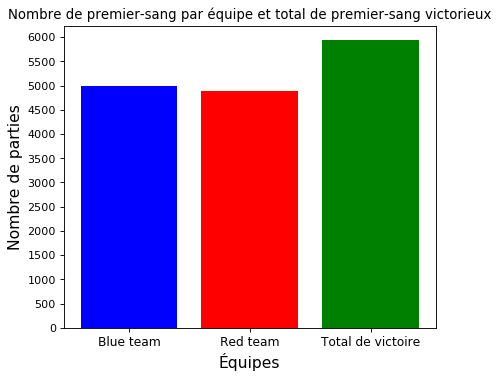

L'équipe obtenant le premier sang est victorieuse dans 60.1% des parties
L'équipe bleue obtient le premier-sang dans 50.5% des parties
L'équipe rouge obtient le premier-sang dans 49.5% des parties


In [19]:
firstBloodRepartition(dfSimplified)

On remarque que l'équipe bleue a légèrement plus tendance à obtenir le premier-sang. Cela peut s'expliquer grâce aux "invasions" de la jungle qui prennent place en début de partie. En effet il arrive souvent qu'une des 2 équipes, voire les 2, décide d'aller à la rencontre de l'équipe adverse pour l'affronter afin de prendre l'avantage le plus tôt possible. La carte étant symétrique par rotation, et les invasions prenant la plupart du temps place sur le bas de la carte, il est possible que le terrain donne l'avantage à l'équipe bleue.  
Concernant le taux de victoire, on peut confirmer qu'obtenir le premier-sang est lié à de meilleures chances de gagner. Tout comme pour les doubles-objectifs, obtenir le premier sang témoigne généralement de meilleures compétences ainsi que de meilleures connaissance du jeu de la part d'un joueur, cette avance est encore plus accentuée par l'or gagnée lors de cette élimination.

### Écart d'or

In [20]:
def goldRepartition(df):
    gold = df["blueGoldDiff"]
    exp = df["blueExperienceDiff"]
    winner = df["blueWins"].copy()
    winner.loc[winner == 1] = "blue"
    winner.loc[winner ==0] = "red"
    
    plt.figure(figsize=(6,7), dpi=80)
    plt.scatter(gold, exp, c = winner)
    plt.xlabel("Or", size=14)
    plt.xticks(np.arange(-10000, 12000, 3000),size=11)
    plt.ylabel("Expérience", size=14)
    plt.yticks(np.arange(-10000, 10000, 1500))
    slope, intercept, r_value, p_value, std_err = stats.linregress(gold, exp)
    fitLine = slope * gold + intercept
    #halfline = -slope * gold + intercept
    plt.plot(gold, fitLine, c='green', linewidth = 4)
    #plt.plot(gold, halfline, c = 'gray', linewidth =4)
    plt.title("Vainqueur selon la différence d'or et d'expérience entre les équipes")
    plt.savefig('images/Winner_by_Gold_Exp.png', bbox_inches='tight')
    
    plt.show()
    
    print("On détermine que la pente liant l'or et l'expérience d'une équipe est d'équation : exp =", str(round(slope, 1)) +"*gold" + str(round(intercept, 1)))

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


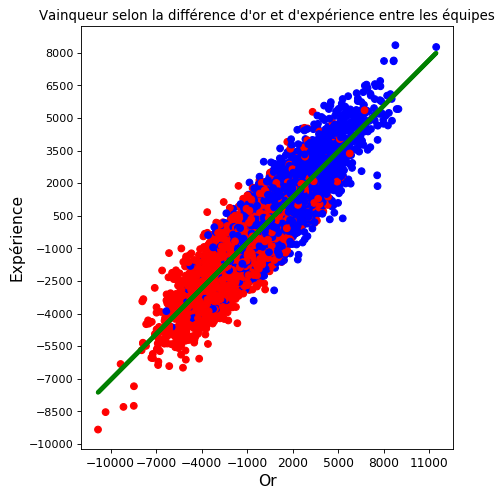

On détermine que la pente liant l'or et l'expérience d'une équipe est d'équation : exp = 0.7*gold-43.7


In [21]:
goldRepartition(dfSimplified)

Ces deux caractéristiques sont les plus importantes pour déterminer la force d'une équipe et semblent corrélées, il n'y a que 2 aspects du jeu qui impactent à la fois l'or et l'expérience de manière significative:
* Les sbires qui offrent un peu d'or et d'expérience (et par extension les morts qui font louper des sbires)
* Les éliminations qui offrent beaucoup d'or et un peu d'expérience  
On remarque qu'une différence d'or et d'expérience trop importante garanti la victoire d'une équipe, il faut donc logiquement capitaliser sur les sbires et les éliminations dès le début de partie.

In [22]:
dfSimplified

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueTowersDestroyed,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,redWardsPlaced,redWardsDestroyed,redAssists,redTowersDestroyed,redTotalMinionsKilled,redTotalJungleMinionsKilled,herald,dragon
0,0,28,2,1,9,6,11,0,195,36,643,-8,15,6,8,0,197,55,-1,-1
1,0,12,1,0,5,5,5,0,174,43,-2908,-1173,12,1,2,1,240,52,0,0
2,0,15,0,0,7,11,4,0,186,46,-1172,-1033,15,3,14,0,203,28,-1,1
3,0,43,1,0,4,5,5,0,201,55,-1321,-7,15,2,10,0,235,47,1,-1
4,0,75,4,0,6,6,6,0,210,57,-1004,230,17,2,7,0,225,67,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9874,1,17,2,1,7,4,5,0,211,69,2519,2469,46,3,7,0,229,34,-1,1
9875,1,54,0,0,6,4,8,0,233,48,782,888,12,21,3,0,206,56,-1,1
9876,0,23,1,0,6,7,5,0,210,45,-2416,-1877,14,0,11,0,261,60,-1,0
9877,0,14,4,1,2,3,3,0,224,48,-839,-1085,66,4,1,0,247,40,-1,1


### Prise de vision
On s'intéresse dans cette section à la prise de vision, c'est à dire aux balises placées  
Le délai de récupération des balises étant d'environ 200 secondes, en comptant les balises que l'on peut acheter dans la boutique, on peut estimer le nombre maximum de balises placées par une équipe à 60 et ainsi éliminer les parties dans lesquelles un joueur à profiter d'un objet pour placer plusieurs dizaines de balises dans sa base. Cela n'a pas d'intérêt, et ne coûte rien au joueur, c'est pourquoi on ne les supprime pas complètement du dataset.

In [35]:
dfVision = df.copy()
dfVision = dfVision[["blueWins", "blueWardsPlaced", "redWardsPlaced"]]
dfVision = dfVision[(dfVision["blueWardsPlaced"] <= 60) & (dfVision["redWardsPlaced"] <= 60)]

In [36]:
def GameByVision(df):
    #bbalises = df[df["blueWardsPlaced"] < 175]
    #balises = balises[balises["blueWardsPl"]]
    
    plt.figure(figsize=(6,5), dpi=80)
    plt.xlabel("Nombre de balises", size=14)
    plt.ylabel("Nombre de parties", size=14)
    
    plt.hist(df["blueWardsPlaced"],bins = 'auto')
    plt.hist(df["redWardsPlaced"], bins = 'auto')
    
    plt.show()


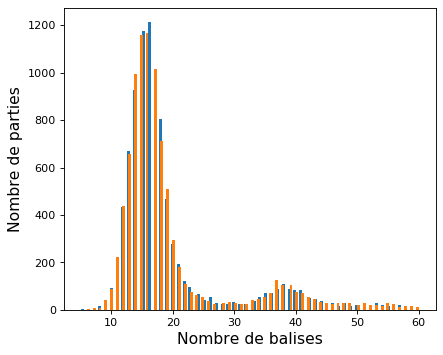

In [37]:
GameByVision(dfVision)

# Modélisation

In [25]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPClassifier as mlp
import sys
df = dfSimplified
part = round(len(df)/10) #découpage du dataset en tranche de 10

## Phase d'entraînement

In [26]:
Xtrain = df.iloc[0:8*part, 1:] #les 8 premiers dixième, et toutes les colonnes sauf la n°0
Ytrain = df.iloc[0:8*part, 0] #les 8 premiers dixième, et la colonne 0 (les target values)

In [27]:
svm1 = svm.SVC() #Support vector machine, c'est là dedans qu'il faut mettre les paramètres
clf = make_pipeline(StandardScaler(), svm1) #je sais pas ce que ça fait
clf.fit(Xtrain, Ytrain) #Training

Pipeline(steps=[('standardscaler', StandardScaler()), ('svc', SVC())])

In [28]:
#pour vérifier le modèle
Xtest = df.iloc[8*part:9*part, 1:] #le 9ème dixième, et toutes les colonnes sauf la n°0
Ytest = df.iloc[8*part:9*part, 0] #le 9ème dixième, et la colonne 0 (lest target values)

In [29]:
resultest = clf.predict(Xtest) #le résultat de la prédiction sur le set de test

In [30]:
def compare(test, Ytest):
    Yarray = Ytest.to_numpy() #transformation du dataframe (pandas) en array
    total = 0 #le nombre total de ligne
    correct = 0 #le nombre de ligne où le guess était bon
    for index in range(len(test)):
        if test[index] == Yarray[index]:
            correct += 1
        total += 1
    print("Total : " + str(total))
    print("Correct : " + str(correct))
    print(str(round(100*correct/total, 1)) + "%")
    
compare(resultest, Ytest)

Total : 988
Correct : 722
73.1%


## Truc